**optoSTING results - Figure 2 - Mathematical theory and numerical simulation of ReLU relation**

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix, eye
from scipy.sparse.linalg import spsolve
from scipy.stats import norm
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
import numba as nb
from matplotlib.gridspec import GridSpec
import pandas as pd
from plotstyle import defaultStyle, save_fig
from pde import ScalarField, CartesianGrid, PDEBase, FieldCollection, FileStorage, movie

# Intuitions

Saving figure intuition


/home/liboyan/Documents/optoSTING/scripts/plotstyle.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


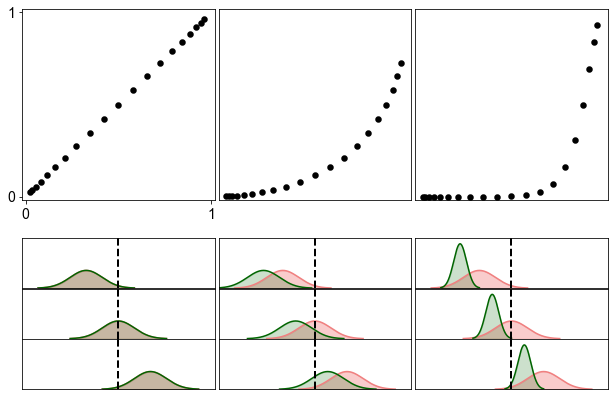

In [2]:
thresh = 0.5
sender_mean = np.arange(0, 1, 0.05)
sender_std = 0.25

fig = plt.figure(figsize=(10.5, 7))
gs1 = GridSpec(1, 3, figure=fig, bottom=0.5, wspace=0.02)
gs2 = GridSpec(3, 3, figure=fig, top=0.425, hspace=0.01, wspace=0.02)
defaultStyle()

for i, (std_ratio, mean_diff) in enumerate(zip([1, 1, 0.4], [0, 0.3, 0.3])):
    receiver_std = sender_std * std_ratio
    receiver_mean = sender_mean - mean_diff
    sars = np.array([1 - norm.cdf((thresh - mu) / sender_std) for mu in sender_mean])
    rars = np.array([1 - norm.cdf((thresh - mu) / receiver_std) for mu in receiver_mean])
    ax1 = fig.add_subplot(gs1[i])
    ax1.scatter(sars, rars, lw=2, s=20, c='k')
    ax1.axis([-0.02, 1.02, -0.02, 1.02])
    ax1.set_xticks([0, 1])
    ax1.set_yticks([0, 1])
    if i > 0:
        ax1.set_xticks([])
        ax1.set_yticks([])
    xdata = np.linspace(-1, 2, 1000)
    for j, mu in enumerate([0, 0.5, 1]):
        ax = fig.add_subplot(gs2[j, i])
        xdata = np.linspace(mu - 3 * sender_std, mu + 3 * sender_std, 1000)
        ax.plot(xdata, norm.pdf(xdata, mu, sender_std), color="lightcoral")
        ax.fill_between(xdata, norm.pdf(xdata, mu, sender_std), alpha=0.4, color="lightcoral")
        xdata = np.linspace(mu - mean_diff - 3 * receiver_std, mu - mean_diff + 3 * receiver_std, 1000)
        ax.plot(xdata, norm.pdf(xdata, mu - mean_diff, receiver_std), color="darkgreen")
        ax.fill_between(xdata, norm.pdf(xdata, mu - mean_diff, receiver_std), alpha=0.2, color="darkgreen")
        ax.axvline(thresh, lw=2, ls="--", c="k")
        ax.axis([-1, 2, 0, 4.5])
        ax.set_xticks([])
        ax.set_yticks([])
save_fig("intuition")

# Steady state solution

$$D\left(\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2}\right) + A - \gamma u = 0$$

$$\left(u_{i,j+1}+u_{i,j-1}+u_{i+1,j}+u_{i-1,j}-4u_{i,j}\right) + h^2\cdot\dfrac{A}{D} - h^2\cdot\dfrac{\gamma}{D} u_{i,j} = 0$$

## Elliptic equation

In [3]:
def elliptic_matrix(n, bc="zero_flux"): 
    row_ind = [i for i in range(n**2-1) if not i % n == n-1] + [i for i in range(1, n**2) if not i % n == 0] + list(range(n**2-n)) + list(range(n, n**2))
    col_ind = [i for i in range(1, n**2) if not i % n == 0] + [i for i in range(n**2-1) if not i % n == n-1] + list(range(n, n**2)) + list(range(n**2-n))
    data = [-1] * (n-1) * n * 2 + [-1] * (n**2*2 - 2*n)
    A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(n**2, n**2))
    if bc == "zero":
        A_arr_diag_compensation == 0
    elif bc == "zero_flux":
        A_arr_diag_compensation = np.array(np.sum(A_arr, axis=1)).flatten()
    row_ind += list(range(n**2))
    col_ind += list(range(n**2))
    data += list(np.array([4] * n**2) - A_arr_diag_compensation - 4)
    A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(n**2, n**2))
    return A_arr

## ReLU with Histogram

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_29567/3420440020.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ar_df = ar_df.append(new_item, ignore_index=True)
/tmp/ipykernel_29567/3420440020.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ar_df = ar_df.append(new_item, ignore_index=True)
/tmp/ipykernel_29567/3420440020.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ar_df = ar_df.append(new_item, ignore_index=True)
/tmp/ipykernel_29567/3420440020.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ar_df = ar_df.append(new_item, ignore_index=True)
/tmp/ipykernel_29567/3420440020.py:31: FutureWarning: The frame.append method is deprecated and will be 

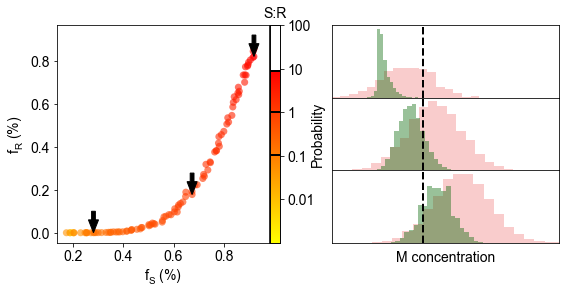

In [4]:
nGrid = 100
gamma = .1
D = .1
a = gamma
a_std = a * 1
thresh = 0.5
A_arr = elliptic_matrix(nGrid)
A_arr += gamma / D * eye(nGrid**2)
cmap = "autumn_r"

m_values = [int(nGrid ** 2 * sr) for sr in np.linspace(0.001, 0.9, 100)]
selected_m_values = np.array([0.1, 1, 10])
selected_m_values = selected_m_values / (1 + selected_m_values) * nGrid ** 2
selected_m_values = np.array([m_values[np.argsort(abs(m_values - m0))[0]] for m0 in selected_m_values])

ar_df = pd.DataFrame()
css = []
crs = []
for i, m in enumerate(tqdm(m_values)):
    s = np.zeros(nGrid ** 2)
    s[np.random.choice(np.arange(nGrid ** 2), m, replace=False)] = 1
    a_arr = np.random.normal(a, a_std, nGrid**2)
    # a_arr[a_arr < 0] = 0
    b = a_arr * s / D
    result_ss = spsolve(A_arr, b)
    cs = result_ss[(s==1)]
    cr = result_ss[(s==0)]
    sar = (cs > thresh).sum() / ((s==1)).sum()
    rar = (cr > thresh).sum() / ((s==0)).sum()
    new_item = {"sar": sar, "rar": rar, "sr_ratio_log": np.log(m/(nGrid**2 - m))}
    ar_df = ar_df.append(new_item, ignore_index=True)
    if m in selected_m_values:
        css.append(cs)
        crs.append(cr)

fig = plt.figure(figsize=(9, 4))
gs1 = GridSpec(1, 2, width_ratios=[20, 1], right=0.47, wspace=0.01)
defaultStyle()
ax_relu = fig.add_subplot(gs1[:, 0])
sns.scatterplot(data=ar_df, x="sar", y="rar", hue="sr_ratio_log", markers="o", 
                linewidth=0, alpha=0.6, s=50, palette=cmap, ax=ax_relu, legend=False)
selected_ar_df = ar_df[np.isin(ar_df.sr_ratio_log.values, np.log(selected_m_values/(nGrid**2 - selected_m_values)))]
ax_relu.set_xlabel("$\mathregular{f_S\;(\%)}$")
ax_relu.set_ylabel("$\mathregular{f_R\;(\%)}$")
# ax_relu.axis([-0.02, 1.02, -0.02, 1.02])

# Colorbar
ax_cbar = fig.add_subplot(gs1[:, 1])
cbar_ticks = [1/100, 1/10, 1, 10, 100]
norm = plt.Normalize(ar_df.sr_ratio_log.min(), ar_df.sr_ratio_log.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=ax_cbar)
cb.set_ticks(np.log(cbar_ticks))
cb.set_ticklabels(cbar_ticks)
ax_cbar_twin = ax_cbar.twiny()
ax_cbar_twin.set_xlabel("S:R", fontsize=14)
ax_cbar_twin.set_xticks([])
for m in selected_m_values:
    ax_cbar.axhline(y=np.log(m/(nGrid**2 - m)), linewidth=2, color="k")
    ax_relu.arrow(ar_df.loc[np.where(ar_df.sr_ratio_log == np.log(m/(nGrid**2 - m)))[0][0], "sar"],
                 ar_df.loc[np.where(ar_df.sr_ratio_log == np.log(m/(nGrid**2 - m)))[0][0], "rar"] + 0.1, 
                  0, -0.1, head_width=0.04, width=0.015, length_includes_head=True, color="k")

gs2 = GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0, left=0.55)
for i in range(3):
    ax = fig.add_subplot(gs2[i])
    hist_kwargs = {"alpha": 0.4, "bins": 20, "ax": ax, "edgecolor": None, "stat": "probability"}
    sns.histplot(css[i], **hist_kwargs, color="lightcoral")
    sns.histplot(crs[i], **hist_kwargs, color="darkgreen")
    ax.set_xlim([-0.5, 2])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.axvline(x=thresh, linestyle="--", linewidth=2, color="k")
    ax.set_yticks([])
    if i == 2:
        # ax.set_xticks([0, 0.5, 1, 2])
        ax.set_xlabel("M concentration")
    if i == 1:
        ax.set_ylabel("Probability")
# save_fig("simulation_ss_short_range_relu")

## Varying diffusion coefficient

In [5]:
nGrid = 100
gamma = .1
a = gamma
a_std = a * 1
thresh = 0.5
cmap = "hsv"


m_values_group = [
    [int(nGrid ** 2 * sr) for sr in np.linspace(0.001, 0.9, 20)],
    [int(nGrid ** 2 * sr) for sr in np.linspace(0.2, 0.6, 20)],
    [int(nGrid ** 2 * sr) for sr in np.linspace(0.4, 0.55, 20)],
]
ars = []
D_values = [.1, .5, 5]

for j, D in enumerate(D_values):
    sar_means = []
    sar_errs = []
    rar_means = []
    rar_errs = []
    for i, m in enumerate(tqdm(m_values_group[j])):
        sars = []
        rars = []
        for _ in range(5):
            A_arr = elliptic_matrix(nGrid)
            A_arr += gamma / D * eye(nGrid**2)
            s = np.zeros(nGrid ** 2)
            s[np.random.choice(np.arange(nGrid ** 2), m, replace=False)] = 1
            a_arr = np.random.normal(a, a_std, nGrid**2)
            b = a_arr * s / D
            result_ss = spsolve(A_arr, b)
            cs = result_ss[(s==1)]
            cr = result_ss[(s==0)]
            sar = (cs > thresh).sum() / ((s==1)).sum()
            rar = (cr > thresh).sum() / ((s==0)).sum()
            sars.append(sar)
            rars.append(rar)
        sar_means.append(np.mean(sars))
        rar_means.append(np.mean(rars))
        sar_errs.append(np.std(sars))
        rar_errs.append(np.std(rars))
    ars.append((sar_means, sar_errs, rar_means, rar_errs))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving figure relu_vs_diffusion


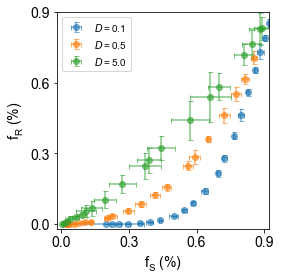

In [6]:
_, ax1 = plt.subplots(1, 1, figsize=(4, 4))
plt.subplots_adjust(wspace=0.15)
defaultStyle()
for i in range(len(D_values)):
    ax1.errorbar(
        x=ars[i][0], 
        y=ars[i][2], 
        yerr=ars[i][3], 
        xerr=ars[i][1], 
        alpha=0.6, 
        label="$D=%.1f$"%D_values[i], 
        marker="o",
        linestyle="",
        capsize=2.5,
    )
    
ax1.set_xlabel("$\mathregular{f_S\;(\%)}$")
ax1.set_ylabel("$\mathregular{f_R\;(\%)}$")
ax1.legend()
ax1.set_xticks([0, 0.3, 0.6, 0.9])
ax1.set_yticks([0, 0.3, 0.6, 0.9])
ax1.axis([-0.02, 0.92, -0.02, 0.9])
save_fig("relu_vs_diffusion")

## Dynamical Range

In [7]:
ars = []
m_values = [int(nGrid ** 2 * sr) for sr in np.linspace(0.01, 0.99, 25)]
for j, D in enumerate(D_values):
    sar_means = []
    sar_errs = []
    rar_means = []
    rar_errs = []
    for m in tqdm(m_values):
        sars = []
        rars = []
        for _ in range(5):
            A_arr = elliptic_matrix(nGrid)
            A_arr += gamma / D * eye(nGrid**2)
            s = np.zeros(nGrid ** 2)
            s[np.random.choice(np.arange(nGrid ** 2), m, replace=False)] = 1
            a_arr = np.random.normal(a, a_std, nGrid**2)
            b = a_arr * s / D
            result_ss = spsolve(A_arr, b)
            cs = result_ss[(s==1)]
            cr = result_ss[(s==0)]
            sar = (cs > thresh).sum() / ((s==1)).sum()
            rar = (cr > thresh).sum() / ((s==0)).sum()
            sars.append(sar)
            rars.append(rar)
        sar_means.append(np.mean(sars))
        rar_means.append(np.mean(rars))
        sar_errs.append(np.std(sars))
        rar_errs.append(np.std(rars))
    ars.append((sar_means, sar_errs, rar_means, rar_errs))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Saving figure response_curve_vs_diffusion


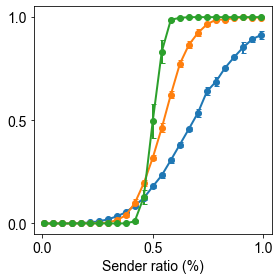

In [8]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
for i in range(3):
    ax.errorbar(np.array(m_values) / nGrid ** 2, ars[i][2], yerr=ars[i][3], capsize=2.5, marker="o", linewidth=2)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel("Sender ratio (%)")
save_fig("response_curve_vs_diffusion")

## Diffusion rate vs. $\Delta\mu$ and $\sigma_1/\sigma_2$

In [9]:
nGrid = 100
gamma = .1
a = gamma
a_std = a * 1
thresh = 0.5

cdiff_mean = []
errdiff_mean = []
serrs_mean = []
rerrs_mean = []

D_values = np.logspace(-1.2, 1.2, 20)
for D in tqdm(D_values):
    cdiffs = []
    errdiffs = []
    serrs = []
    rerrs = []
    for _ in range(5):
        A_arr = elliptic_matrix(nGrid)
        A_arr += gamma / D * eye(nGrid**2)
        s = np.zeros(nGrid ** 2)
        s[np.random.choice(np.arange(nGrid ** 2), nGrid ** 2 // 2, replace=False)] = 1
        a_arr = np.random.normal(a, a_std, nGrid**2)
        b = a_arr * s / D
        result_ss = spsolve(A_arr, b)
        cs = result_ss[(s==1)]
        cr = result_ss[(s==0)]
        sar = (cs > thresh).sum() / ((s==1)).sum()
        rar = (cr > thresh).sum() / ((s==0)).sum()
        cdiffs.append(np.mean(cs) - np.mean(cr))
        errdiffs.append(np.std(cs) / np.std(cr))
        serrs.append(np.std(cs))
        rerrs.append(np.std(cr))
    cdiff_mean.append(np.mean(cdiffs))
    errdiff_mean.append(np.mean(errdiffs))
    serrs_mean.append(np.mean(serrs))
    rerrs_mean.append(np.mean(rerrs))

  0%|          | 0/20 [00:00<?, ?it/s]

Saving figure diffusion_rate_vs_delta_mu_delta_sigma


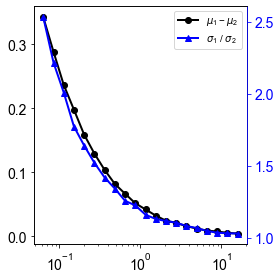

In [10]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
ln1 = ax.plot(D_values, cdiff_mean, marker="o", label=r"$\mu_1 - \mu_2$", linewidth=2, markersize=6, c="k")
ax2 = ax.twinx()
ln2 = ax2.plot(D_values, errdiff_mean, marker="^", label=r"$\sigma_1\;/\;\sigma_2$", linewidth=2, markersize=6, c="blue")
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax2.spines['right'].set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax.set_yticks([0, 0.1, 0.2, 0.3])
ax2.set_yticks([1, 1.5, 2, 2.5])
ax.legend(lns, labs, loc="best")
ax.set_xscale('log')
save_fig("diffusion_rate_vs_delta_mu_delta_sigma")

## Density effect

  0%|          | 0/20 [00:00<?, ?it/s]

Saving figure density_effect


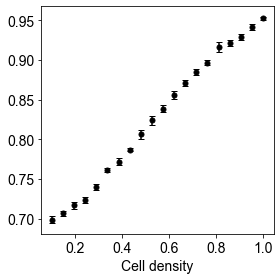

In [11]:
nGrid = 100
gamma = 1
a = gamma
a_std = a * 1
thresh = 0.5

m_values_group = [
    [int(nGrid ** 2 * sr) for sr in np.linspace(0.001, 0.8, 100)],
    [int(nGrid ** 2 * sr) for sr in np.linspace(0.15, 0.55, 100)],
    [int(nGrid ** 2 * sr) for sr in np.linspace(0.32, 0.45, 100)],
]
ar_df = pd.DataFrame()
ars_mean = []
ars_err = []
density = np.linspace(0.1, 1, 20)
D_values = density ** 2

for D in tqdm(D_values):
    ars = []
    for _ in range(5):
        A_arr = elliptic_matrix(nGrid)
        A_arr += gamma / D * eye(nGrid**2)
        s = np.ones(nGrid ** 2)
        a_arr = np.random.normal(a, a_std, nGrid**2)
        b = a_arr * s / D
        result_ss = spsolve(A_arr, b)
        ar = (result_ss > thresh).sum() / (nGrid**2)
        ars.append(ar)
    ars_mean.append(np.mean(ars))
    ars_err.append(np.std(ars))

_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.errorbar(density, ars_mean, ars_err, color="k", linestyle="", capsize=3, marker="o", markersize=5)
ax.set_xlabel("Cell density")
save_fig("density_effect")

## Tuning $D$ and $\gamma$

In [12]:
from itertools import product

nGrid = 50
thresh = 0.5
cmap = "hsv"


m_values_group = [int(nGrid ** 2 * sr) for sr in np.linspace(0.001, 0.99, 500)]
ars = []
D_values = np.arange(0.25, 2, 0.25)
gamma_values = np.arange(0.025, 0.2, 0.025)
D_gamma_comb = list(product(D_values, gamma_values))

for j, (D, gamma) in enumerate(tqdm(D_gamma_comb)):
    a = gamma
    a_std = a * 1
    sar_means = []
    rar_means = []
    for i, m in enumerate(m_values_group):
        sars = []
        rars = []
        for _ in range(1):
            A_arr = elliptic_matrix(nGrid)
            A_arr += gamma / D * eye(nGrid**2)
            s = np.zeros(nGrid ** 2)
            s[np.random.choice(np.arange(nGrid ** 2), m, replace=False)] = 1
            a_arr = np.random.normal(a, a_std, nGrid**2)
            b = a_arr * s / D
            result_ss = spsolve(A_arr, b)
            cs = result_ss[(s==1)]
            cr = result_ss[(s==0)]
            sar = (cs > thresh).sum() / ((s==1)).sum()
            rar = (cr > thresh).sum() / ((s==0)).sum()
            sars.append(sar)
            rars.append(rar)
        sar_means.append(np.mean(sars))
        rar_means.append(np.mean(rars))
    ars.append((sar_means, rar_means))

  0%|          | 0/49 [00:00<?, ?it/s]

Saving figure relu_heatmap


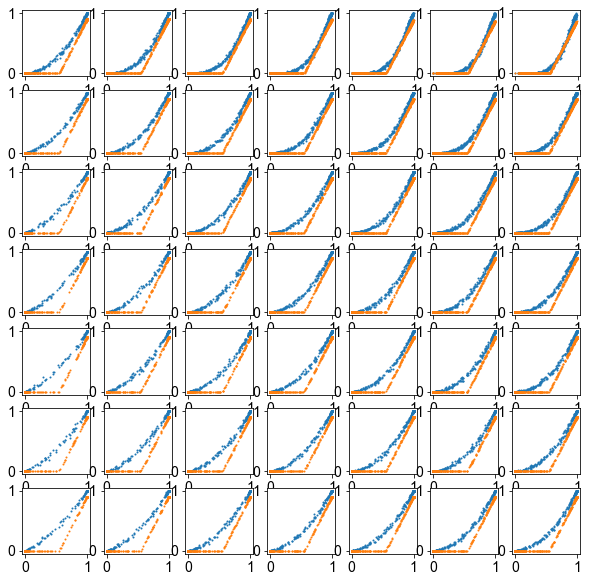

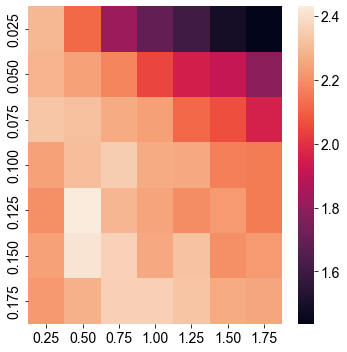

In [15]:
_, ax = plt.subplots(len(D_values), len(gamma_values), figsize=(10, 10))
mse_mat = np.empty((len(D_values), len(gamma_values)))
for i in range(len(D_values)):
    for j in range(len(gamma_values)):
        sar_means, rar_means = ars[i * len(D_values) + j]
        sar_means, rar_means = np.array(sar_means), np.array(rar_means)
        rar_theory = (sar_means - 0.55) * 2 * (sar_means > 0.55) 
        ax[i, j].scatter(sar_means, rar_means, s=1)
        ax[i, j].scatter(sar_means, rar_theory, s=1)
        mse = np.sqrt(np.sum((rar_theory - rar_means) ** 2))
        mse_mat[i, j] = mse
# print(mse_mat)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(mse_mat)
ax.set_xticks(np.arange(len(D_values)) + 0.5)
ax.set_yticks(np.arange(len(gamma_values)) + 0.5)
ax.set_xticklabels(["%.2f"%D for D in D_values])
ax.set_yticklabels(["%.3f"%gamma for gamma in gamma_values])
save_fig("relu_heatmap")

# Dynamical model

## Equations

$$\begin{align}
& \dfrac{\partial u}{\partial t} = D\nabla^2 u + \alpha - k_{\mathrm{on}} u v + k_{\mathrm{off}} w \\
& \dfrac{\partial v}{\partial t} = - k_{\mathrm{on}} u v + k_{\mathrm{off}} w \\
& \dfrac{\partial w}{\partial t} = k_{\mathrm{on}} u v - k_{\mathrm{off}} w - k_{\mathrm{act}} w \dfrac{p^n}{p^n + K^n} - k_{\mathrm{basal}}\\
& \dfrac{\partial p}{\partial t} = k_{\mathrm{act}} w \dfrac{p^n}{p^n + K^n} + k_{\mathrm{basal}} - k_{\mathrm{trans}}p\\
& \dfrac{\partial q}{\partial t} = k_{\mathrm{trans}}p
\end{align}$$

## Single cell dynamics (ODE)

In [3]:
"""Invariable parameters"""
nGrid = 50
D = 1.5e-4
a_mean = 1e-3
a_std = 1 * a_mean
kon = 1
koff = 1
kact = 1e-2
n = 2
K = 0.35
kbasal = 1e-5
ktrans = 1e-3

  0%|          | 0/3 [00:00<?, ?it/s]

Saving figure single_cell_STING_dynamics


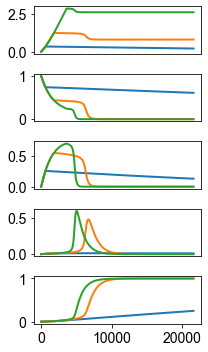

In [17]:
def pathway_activation(t, y, duration, a, kon, koff, kact, n, K, kbasal, ktrans):
    u, v, w, p, q = y
    dudt = a * (t < duration) - kon * u * v + koff * w
    dvdt = - kon * u * v + koff * w
    dwdt = kon * u * v - koff * w - kact * w * p ** n / (K ** n + p ** n) - kbasal * (w > 0)
    dpdt = kact * w * p ** n / (K ** n + p ** n) + kbasal * (w > 0) - ktrans * p
    dqdt = ktrans * p
    return [dudt, dvdt, dwdt, dpdt, dqdt]


_, ax = plt.subplots(5, 1, figsize=(3, 5))
plt.subplots_adjust(hspace=0.04)
defaultStyle()
for duration in tqdm([600, 1800, 3600]):
    sol = solve_ivp(pathway_activation, [0, 3600 * 6], [0, 1, 0, 0, 0], args=(duration, a_mean, kon, koff, kact, n, K, kbasal, ktrans), dense_output=True)
    t = np.linspace(0, 3600 * 6, 1000)
    z = sol.sol(t)
    for i in range(5):
        ax[i].plot(t, z[i], lw=2, label="%d min"%duration)
        if i != 4:
            ax[i].set_xticks([])
# ax[0].legend(loc="best")
save_fig("single_cell_STING_dynamics")

## Reaction-diffusion system (PDE)

### PDE

In [6]:
class SRSystem_2D(PDEBase):
    
    def __init__(self, initial_activ_cells, duration, bc=[{"derivative": 0}] * 2):
        self.initial_activ_cells = initial_activ_cells
        self.bc = bc
        self.check_implementation = False
        self.duration = duration
        self.noise = 0

    def get_initial_state(self, grid):
        """Initial condition"""
        initial_values = [0, 1, 0, 0, 0]
        labels = ["CDG", "STING", "STING-CDG", "STING puncta", "STING translocator"]
        return FieldCollection(
            [ScalarField(grid, data=i, label=label) for i, label in zip(initial_values, labels)]
        )

    def evolution_rate(self, state, t=0):
        u, v, w, p, q = state
        production_arr = np.random.normal(a_mean, a_std, u.shape)
        u_t = (
            D * u.laplace(bc=self.bc)
            + production_arr * self.initial_activ_cells * (t < self.duration)
            - kon * u * v + koff * w
        )
        v_t = - kon * u * v + koff * w
        w_t = kon * u * v - koff * w - kact * w * p ** n / (K ** n + p ** n) - kbasal * (w > 0)
        p_t = kact * w * p ** n / (K ** n + p ** n) + kbasal * (w > 0) - ktrans * p
        q_t = ktrans * p
        return FieldCollection([u_t, v_t, w_t, p_t, q_t])

    def _make_pde_rhs_numba(self, state):
        
        duration = self.duration
        production_arr = np.random.normal(a_mean, a_std, state[0].data.shape)
        laplace = state.grid.make_operator("laplace", bc=self.bc)
        initial_activ_cells = self.initial_activ_cells

        @nb.jit
        def pde_rhs(state_data, t):
            u, v, w, p = state_data[0], state_data[1], state_data[2], state_data[3]
            rate = np.empty_like(state_data)
            rate[0] = (
                D * laplace(u)
                + production_arr * initial_activ_cells * np.float64(t < duration)
                - kon * u * v + koff * w
            )
            rate[1] = - kon * u * v + koff * w
            rate[2] = kon * u * v - koff * w - kact * w * p ** n / (K ** n + p ** n) - kbasal * (w > 0)
            rate[3] = kact * w * p ** n / (K ** n + p ** n) + kbasal * (w > 0) - ktrans * p
            rate[4] = ktrans * p
            return rate
        return pde_rhs
    
    
def initialize_cell_map_2D(sr, size=(nGrid, nGrid)):
    cell_map = np.zeros(size).flatten()
    n_sender = int(len(cell_map) * sr)
    cell_map[np.random.choice(np.arange(len(cell_map)), n_sender, replace=False)] = 1
    cell_map = cell_map.reshape(size)
    return cell_map

### Dynamical results

In [7]:
dt = 0.01
tspan = 3600 * 6
sr = 0.2
duration = 10800
grid = CartesianGrid([[0, nGrid]] * 2, nGrid, periodic=False)
s = initialize_cell_map_2D(sr=sr)
eq = SRSystem_2D(initial_activ_cells=s, duration=duration)
state = eq.get_initial_state(grid)
storage = FileStorage("../results/sol/2D_STING_spatial.npz")
result = eq.solve(state, t_range=tspan, dt=dt, tracker=['consistency', 'progress', storage.tracker(60)])
movie(storage, filename="../figures/2D_STING_spatial.mov", progress=True)

  0%|          | 0/21600.0 [00:00<?, ?it/s]

Saving figure STING_dynamics_distribution


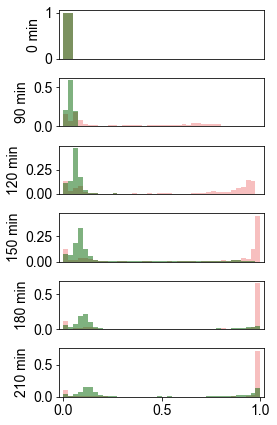

In [72]:
_, ax = plt.subplots(6, 1, figsize=(4, 6))
defaultStyle()
plt.subplots_adjust(hspace=0)
translocator_storage = storage.extract_field('STING translocator')
i = 0
for tp in translocator_storage.items():
    t, data = tp
    if int(t) in [0] + [5400 + 1800 * i for i in range(5)]:
        sender_data = data.data[s==1].flatten()
        receiver_data = data.data[s==0].flatten()
        hist_kwargs = {"alpha": 0.5, "ax": ax[i], "stat": "probability", "edgecolor": None}
        if i == 0:
            hist_kwargs["bins"] = 20
        else:
            hist_kwargs["binwidth"] = 0.025
        sns.histplot(sender_data, color="lightcoral", **hist_kwargs)
        sns.histplot(receiver_data, color="darkgreen", **hist_kwargs)
        ax[i].set_xlim([-0.02, 1.02])
        if i < len(ax) - 1:
            ax[i].set_xticks([])
        ax[i].set_ylabel("%d min"%(int(t) / 60))
        i += 1
save_fig("STING_dynamics_distribution")

### Varying lighting durations

In [ ]:
tspan = 3600 * 6
dt = 0.1
cs_group = []
cr_group = []
sr_values = [0.005] + [0.01 * i for i in range(1, 10)] + [0.1 * i for i in range(1, 10)] + [0.9 + 0.01 * i for i in range(1, 10)]
for duration in [1800, 3600, 10800]:
    sol_group = []
    for sr in tqdm(sr_values):
        for _ in range(3):
            grid = CartesianGrid([[0, nGrid]] * 2, nGrid, periodic=False)
            s = initialize_cell_map_2D(sr=sr)
            eq = SRSystem_2D(initial_activ_cells=s, duration=duration)
            state = eq.get_initial_state(grid)
            # run a simulation and write the results
            result = eq.solve(state, t_range=tspan, dt=dt, tracker=['consistency'])
            cs = result[-1].data[s==1]
            cr = result[-1].data[s==0]
            new_item = {"sr": sr, "cs": cs, "cr": cr}
            sol_group.append(new_item)
    np.save("../results/sol_%d.npy"%duration, sol_group)

Saving figure durations_vs_relu_sting_model


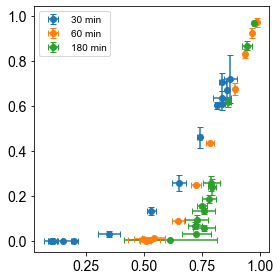

In [6]:
def processing_pde_sol(sol_group):
    sol_df = pd.DataFrame()
    thresh = 0.6
    for sol in sol_group:
        sol_df = sol_df.append(sol, ignore_index=True)
    sol_df["sar"] = sol_df.cs.apply(lambda cs: (cs>thresh).sum()) / sol_df.sr / nGrid**2
    sol_df["rar"] = sol_df.cr.apply(lambda cr: (cr>thresh).sum()) / (1-sol_df.sr) / nGrid**2
    sar_mean = [sol_df[sol_df.sr == sr].sar.mean() for sr in sol_df.sr.unique()]
    rar_mean = [sol_df[sol_df.sr == sr].rar.mean() for sr in sol_df.sr.unique()]
    sar_err = [sol_df[sol_df.sr == sr].sar.std() for sr in sol_df.sr.unique()]
    rar_err = [sol_df[sol_df.sr == sr].rar.std() for sr in sol_df.sr.unique()]
    return np.array(sar_mean), np.array(rar_mean), np.array(sar_err), np.array(rar_err)


defaultStyle()
_, ax = plt.subplots(1, 1, figsize=(4, 4))
for i, duration in enumerate([1800, 3600, 10800]):
    sol_group = np.load("../results/sol_%d.npy"%duration, allow_pickle=True)
    sar_mean, rar_mean, sar_err, rar_err = processing_pde_sol(sol_group)
    if i == 0:
        selected_indices = np.array([2 * i for i in range(8)] + list(range(15, 20)) + [20 + 2 * i for i in range(1, 4)])
    elif i == 1:
        selected_indices = np.array([2 * i for i in range(6)] + list(range(11, 17)))
    elif i == 2:
        selected_indices = np.array(list(range(0, 13)))
    ax.errorbar(
        x=sar_mean[selected_indices], 
        y=rar_mean[selected_indices], 
        xerr=sar_err[selected_indices], 
        yerr=rar_err[selected_indices], 
        linestyle='', 
        marker="o",
        capsize=3,
        label="%d min"%(duration/60)
    )
ax.legend(loc='best')
save_fig("durations_vs_relu_sting_model")